In [1]:
#%matplotlib inline
%matplotlib nbagg

In [2]:
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt
from matplotlib.widgets import SpanSelector, Button
from matplotlib import patches

# NIFTY

## [Table of Content](#content) <a class="anchor" id="content"></a>

* [Create Synthetic Absorption Line](#section_1)
* [Create GUI](#section_2)
    * [Span Selector Example](#section_2_1)
    * [Span Selector with Multiple Regions](#section_2_2)
    * [Two Span Selector Functions](#section_2_3)
    * [Add Buttons](#section_2_4)
    * [Cycle Through DIBS](#section_2_5)
* [Calculations](#section_3)
* [Read Spectrum from FITS File](#section_4)
* [Store and Export Results](#section_5)

## [Create Synthetic Absorption Line](#content)<a class="anchor" id="section_1"></a>

<IPython.core.display.Javascript object>


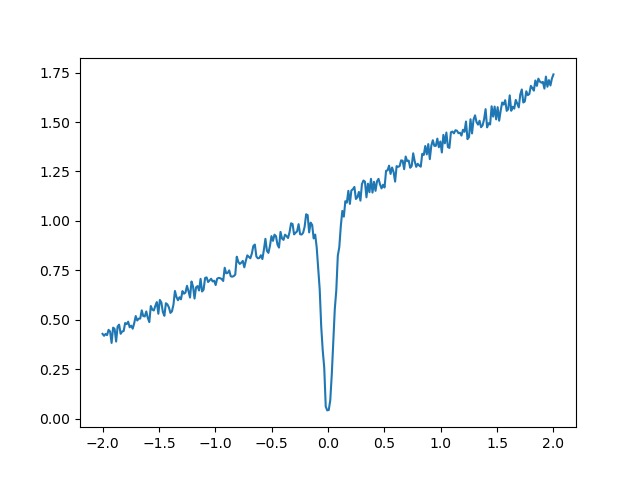

In [12]:
n = 300
xs = np.linspace(-2,2,n)

gaussian = signal.gaussian(n,4)
noise = np.random.rand(n)
sn = 10
shift = [x / 3 for x in xs]

ys = 1 - gaussian + noise / sn + shift

fig, ax = plt.subplots()
ax.plot(xs, ys)
plt.show()

<IPython.core.display.Javascript object>


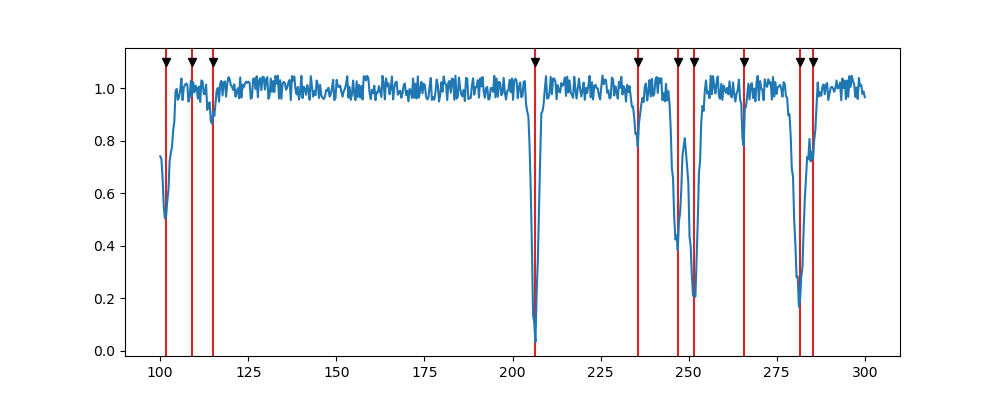

In [35]:
def create_spectrum(x_range=(100,200), sigma_range=(1,5), strength_range=(0,1), number_of_values=300, number_of_dibs=3, sn=10):
    if x_range is None:
        x_range_min, x_range_max = (100, 500)
    else:
        x_range_min, x_range_max = x_range

    # if number_of_values is None:
    number_of_values = (x_range_max - x_range_min) * 3

    xs = np.linspace(x_range_min, x_range_max, number_of_values)
    noise = np.random.rand(xs.size)
    ys = 1 + noise / sn - np.mean(noise / sn) 

    sigma_min, sigma_max = sigma_range
    strength_min, strength_max = strength_range
    dibs = []
    for i in range(number_of_dibs):
        sigma = sigma_min + np.random.rand() * sigma_max
        strength = strength_min + np.random.rand() * strength_max
        gaussian = signal.gaussian(number_of_values * 2, sigma)
        dib_index = int(np.random.rand() * number_of_values)
        dibs.append(xs[number_of_values-dib_index])
        ys = ys - strength * gaussian[dib_index:dib_index+number_of_values]
    return xs, ys, dibs


xs, ys, dibs = create_spectrum(x_range=(100,300), sigma_range=(1,5), strength_range=(0,1), number_of_values=300, number_of_dibs=10, sn=10)
dibs.sort()

fig, ax = plt.subplots(figsize=(10, 4))
for dib in dibs:
    ax.axvline(dib, 0, 2, color="C3")
    
ax.plot(dibs, [1.1]*len(dibs), "kv")

ax.plot(xs, ys)
plt.show()

## [Create GUI](#content) <a class="anchor" id="section_2"></a>

### [Span Selector Example](#content) <a class="anchor" id="section_2_1"></a>

In [5]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6))
ax1.set(facecolor='#FFFFCC')

ax1.plot(xs, ys, '-')
ax1.set_ylim(-2, 2)
ax1.set_title('Press left mouse button and drag to test')

ax2.set(facecolor='#FFFFCC')
#line2, = ax2.plot(x, y, '-')
line2, = ax2.plot(xs, ys, '-')


def onselect(xmin, xmax):
    indmin, indmax = np.searchsorted(xs, (xmin, xmax))
    indmax = min(len(xs) - 1, indmax)
    
    thisx = xs[indmin:indmax]
    thisy = ys[indmin:indmax]
    
    if thisx.size <= 1:
        thisx = xs
        thisy = ys
    
    fig.suptitle(f'Range from {round(thisx.min(), 3)} to {round(thisx.max(), 3)}', fontsize=16)

    line2.set_data(thisx, thisy)
    ax2.set_xlim(thisx[0], thisx[-1])
    ax2.set_ylim(thisy.min(), thisy.max())
    fig.canvas.draw()

# Set useblit=True on most backends for enhanced performance.
span = SpanSelector(ax1, onselect, 'horizontal', useblit=True,
                    rectprops=dict(alpha=0.5, facecolor='red'))


plt.show()

<IPython.core.display.Javascript object>

### [Span Selector with Multiple Regions](#content) <a class="anchor" id="section_2_2"></a>

In [6]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6), constrained_layout=True)

#ax1.set(facecolor='#FFFFCC')
ax1.plot(xs, ys, '-', color="C0")
ax1.set_title('Full Spectrum')

#ax2.set(facecolor='#FFFFCC')
ax2.plot(xs, ys, '-', color="C0")
ax2.set_title('DIB Region')

xs_fit_data = np.array([])
ys_fit_data = np.array([])


def onselect(xmin, xmax):
    # uff, maybe there is a better solution then this
    global xs_fit_data
    global ys_fit_data
    
    # get x and y values of selection
    indmin, indmax = np.searchsorted(xs, (xmin, xmax))
    indmax = min(len(xs) - 1, indmax)
    
    thisx = xs[indmin:indmax]
    thisy = ys[indmin:indmax]
    
    # reset plot for empty selection
    if thisx.size <= 1:
        ax2.clear()
        ax2.plot(xs, ys, '-', color="C0")
        
        xs_fit_data = np.array([])
        ys_fit_data = np.array([])
        return
    
    # append to fit region and attempt to fit
    xs_fit_data = np.append(thisx, xs_fit_data)
    ys_fit_data = np.append(thisy, ys_fit_data)
    k, d = np.polyfit(xs_fit_data, ys_fit_data, 1)
    ys_fit = [k * x + d for x in xs]
    
    ax2.clear()
    ax2.plot(xs, ys, '-', color="C0")
    ax2.plot(xs, ys_fit, '-', color="k", alpha=0.5)
    #ax2.plot(thisx, thisy, '-', color="C1", linewidth=2)
    ax2.plot(xs_fit_data, ys_fit_data, 'o', color="C1", alpha=0.5)
    fig.canvas.draw()

# Set useblit=True on most backends for enhanced performance.
span = SpanSelector(ax2, onselect, 'horizontal', useblit=True,
                    rectprops=dict(alpha=0.5, facecolor='yellow'))


plt.show()

<IPython.core.display.Javascript object>

### [Two Span Selector Functions](#content) <a class="anchor" id="section_2_3"></a>

<IPython.core.display.Javascript object>


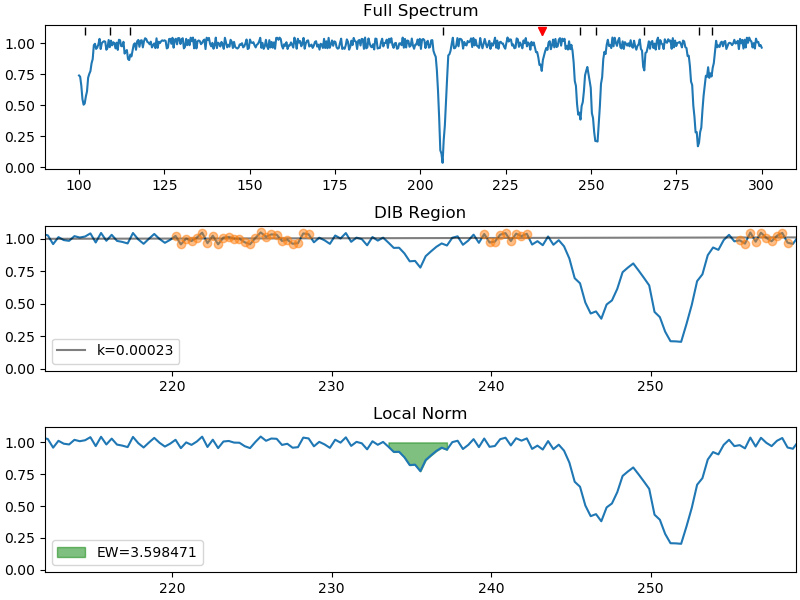

In [48]:
def reset_plot():
    global xs_fit_data
    global ys_fit_data
    global ys_fit
    global ys_norm
    global selection
    
    selection_indmin, selection_indmax = find_selection_range()
    
    #ax1.set(facecolor='#FFFFCC')
    ax1.clear()
    ax1.plot(xs, ys, '-', color="C0")
    ax1.plot(dibs, [1.1]*len(dibs), "k|")
    ax1.plot(dibs[selection], [1.1], "rv")
    ax1.set_title('Full Spectrum')

    #ax2.set(facecolor='#FFFFCC')
    ax2.clear()
    ax2.plot(xs, ys, '-', color="C0")
    ax2.set_xlim(dibs[selection] * 0.9, dibs[selection] * 1.1)
    ax2.set_title('DIB Region')

    ax3.clear()
    ax3.plot(xs, ys, '-', color="C0")
    ax3.set_xlim(dibs[selection] * 0.9, dibs[selection] * 1.1)
    ax3.set_title('Local Norm')
    
    fig.canvas.draw()

    xs_fit_data = np.array([])
    ys_fit_data = np.array([])
    ys_fit = np.array([])
    ys_norm = np.array([])


def onselect_fit_range(xmin, xmax):
    # uff, maybe there is a better solution then this
    global xs_fit_data
    global ys_fit_data
    global ys_fit
    global ys_norm
    
    # get x and y values of selection
    indmin, indmax = np.searchsorted(xs, (xmin, xmax))
    indmin = max(0, indmin - 2)
    indmax = min(len(xs) - 1, indmax)
    
    thisx = xs[indmin:indmax]
    thisy = ys[indmin:indmax]
    
    # reset plot for empty selection
    if thisx.size <= 1:
        ax2.clear()
        ax2.plot(xs, ys, '-', color="C0")
        
        xs_fit_data = np.array([])
        ys_fit_data = np.array([])
        return
    
    # append to fit region and attempt to fit
    xs_fit_data = np.append(thisx, xs_fit_data)
    ys_fit_data = np.append(thisy, ys_fit_data)
    k, d = np.polyfit(xs_fit_data, ys_fit_data, 1)
    ys_fit = [k * x + d for x in xs]
    ys_norm = ys / ys_fit
    
    # redraw everything
    ax2.clear()
    ax2.set_title('DIB Region')
    ax2.set_xlim(dibs[selection] * 0.9, dibs[selection] * 1.1)
    ax2.plot(xs, ys, '-', color="C0")
    ax2.plot(xs, ys_fit, '-', color="k", alpha=0.5, label=f"k={round(k,6)}")
    #ax2.plot(thisx, thisy, '-', color="C1", linewidth=2)
    ax2.plot(xs_fit_data, ys_fit_data, 'o', color="C1", alpha=0.5)
    ax2.legend()
    
    ax3.clear()
    ax3.set_title('Local Norm')
    ax3.set_xlim(dibs[selection] * 0.9, dibs[selection] * 1.1)
    ax3.axhline(1, xs.min(), xs.max(), color="k", alpha=0.5)
    ax3.plot(xs, ys_norm)
    
    fig.canvas.draw()

    
def onselect_ew_range(xmin, xmax):
    global ys_norm
    # get x and y values of selection
    indmin, indmax = np.searchsorted(xs, (xmin, xmax))
    indmin = max(0, indmin - 2)
    indmax = min(len(xs) - 1, indmax)
    diff = ys_norm[indmin:indmax] * (xs[1] - xs[0])
    ew = sum(diff)
    
    ax3.clear()
    ax3.set_title('Local Norm')
    ax3.set_xlim(dibs[selection] * 0.9, dibs[selection] * 1.1)
    ax3.axhline(1, xs.min(), xs.max(), color="k", alpha=0.5)
    ax3.plot(xs, ys_norm)
    ax3.fill_between(xs, ys_norm, 1, where=(xs > xs[indmin]) & (xs <= xs[indmax]), 
                     color="green", alpha=0.5, label=f'EW={round(ew, 6)}')
    ax3.legend()
    fig.canvas.draw()


def next_dib():
    global selection
    global dibs
    selection = (selection + 1) % len(dibs)
    reset_plot()
    

def find_selection_range():
    global selection
    global dibs
    xmin = dibs[selection] * (1. - 0.1)
    xmax = dibs[selection] * (1. + 0.1)
    indmin, indmax = np.searchsorted(xs, (xmin, xmax))
    indmin = max(0, indmin - 2)
    indmax = min(len(xs) - 1, indmax)
    return indmin, indmax

def onpress(event):
    if event.key == 'r':
        reset_plot()
    if event.key == 'n':
        next_dib()
        
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(8, 6), constrained_layout=True)

selection = 0
reset_plot()

cid = fig.canvas.mpl_connect('key_press_event', onpress)

# Set useblit=True on most backends for enhanced performance.
span_fit = SpanSelector(ax2, onselect_fit_range, 'horizontal', useblit=True,
                    rectprops=dict(alpha=0.5, facecolor='yellow'))

span_ew = SpanSelector(ax3, onselect_ew_range, 'horizontal', useblit=True,
                    rectprops=dict(alpha=0.5, facecolor='yellow'))

plt.show()

### [Add Buttons](#content) <a class="anchor" id="section_2_4"></a>

In [8]:
freqs = np.arange(2, 20, 3)

fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.2)
t = np.arange(0.0, 1.0, 0.001)
s = np.sin(2*np.pi*freqs[0]*t)
l, = plt.plot(t, s, lw=2)


class Index(object):
    ind = 0

    def next(self, event):
        self.ind += 1
        i = self.ind % len(freqs)
        ydata = np.sin(2*np.pi*freqs[i]*t)
        l.set_ydata(ydata)
        plt.draw()

    def prev(self, event):
        self.ind -= 1
        i = self.ind % len(freqs)
        ydata = np.sin(2*np.pi*freqs[i]*t)
        l.set_ydata(ydata)
        plt.draw()

callback = Index()
axprev = plt.axes([0.7, 0.05, 0.1, 0.075])
axnext = plt.axes([0.81, 0.05, 0.1, 0.075])
bnext = Button(axnext, 'Next')
bnext.on_clicked(callback.next)
bprev = Button(axprev, 'Previous')
bprev.on_clicked(callback.prev)

plt.show()

<IPython.core.display.Javascript object>

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(8, 6), constrained_layout=True)

def reset_ax1():
    ax1.plot(xs, ys, '-', color="C0")
    ax1.set_title('Full Spectrum')

def reset_ax2():
    ax2.plot(xs, ys, '-', color="C0")
    ax2.set_title('DIB Region')

def reset_ax3():
    ax3.plot(xs, ys, '-', color="C0")
    ax3.set_title('Local Norm')

def reset_all_ax():
    reset_ax1()
    reset_ax2()
    reset_ax3()

reset_all_ax()

xs_fit_data = np.array([])
ys_fit_data = np.array([])
ys_fit = np.array([])
ys_norm = np.array([])


def onselect_fit_range(xmin, xmax):
    # uff, maybe there is a better solution then this
    global xs_fit_data
    global ys_fit_data
    global ys_fit
    global ys_norm
    
    # get x and y values of selection
    indmin, indmax = np.searchsorted(xs, (xmin, xmax))
    indmin = max(0, indmin - 2)
    indmax = min(len(xs) - 1, indmax)
    
    thisx = xs[indmin:indmax]
    thisy = ys[indmin:indmax]
    
    # reset plot for empty selection
    if thisx.size <= 1:
        ax2.clear()
        ax2.plot(xs, ys, '-', color="C0")
        
        xs_fit_data = np.array([])
        ys_fit_data = np.array([])
        return
    
    # append to fit region and attempt to fit
    xs_fit_data = np.append(thisx, xs_fit_data)
    ys_fit_data = np.append(thisy, ys_fit_data)
    k, d = np.polyfit(xs_fit_data, ys_fit_data, 1)
    ys_fit = [k * x + d for x in xs]
    ys_norm = ys / ys_fit
    
    # redraw everything
    ax2.clear()
    ax2.plot(xs, ys, '-', color="C0")
    ax2.plot(xs, ys_fit, '-', color="k", alpha=0.5)
    #ax2.plot(thisx, thisy, '-', color="C1", linewidth=2)
    ax2.plot(xs_fit_data, ys_fit_data, 'o', color="C1", alpha=0.5)
    
    ax3.clear()
    ax3.axhline(1, xs.min(), xs.max(), color="k", alpha=0.5)
    ax3.plot(xs, ys_norm)
    
    fig.canvas.draw()

    
def onselect_ew_range(xmin, xmax):
    # get x and y values of selection
    indmin, indmax = np.searchsorted(xs, (xmin, xmax))
    indmin = max(0, indmin - 2)
    indmax = min(len(xs) - 1, indmax)
    
    ax3.clear()
    ax3.axhline(1, xs.min(), xs.max(), color="k", alpha=0.5)
    ax3.plot(xs, ys_norm)
    ax3.fill_between(xs, ys_norm, 1, where=(xs > xs[indmin]) & (xs <= xs[indmax]), color="green", alpha=0.5)
    fig.canvas.draw()

    
class Index(object):
    ind = 0

    def next(self, event):
        self.ind += 1
        i = self.ind % len(freqs)
        ydata = np.sin(2*np.pi*freqs[i]*t)
        l.set_ydata(ydata)
        plt.draw()

    def prev(self, event):
        self.ind -= 1
        i = self.ind % len(freqs)
        ydata = np.sin(2*np.pi*freqs[i]*t)
        l.set_ydata(ydata)
        plt.draw()

callback = Index()
axprev = plt.axes([0.7, 0.05, 0.1, 0.075])
axnext = plt.axes([0.81, 0.05, 0.1, 0.075])
bnext = Button(axnext, 'Next')
bnext.on_clicked(callback.next)
bprev = Button(axprev, 'Previous')
bprev.on_clicked(callback.prev)

# Set useblit=True on most backends for enhanced performance.
span_fit = SpanSelector(ax2, onselect_fit_range, 'horizontal', useblit=True,
                    rectprops=dict(alpha=0.5, facecolor='yellow'))

span_ew = SpanSelector(ax3, onselect_ew_range, 'horizontal', useblit=True,
                    rectprops=dict(alpha=0.5, facecolor='yellow'))

plt.show()

<IPython.core.display.Javascript object>

### Cycle Through DIBS <a class="anchor" id="section_2_5"></a>

In [10]:
# TODO

## [Calculations](#content) <a class="anchor" id="section_3"></a>

In [11]:
diff = 1 - (1 - gaussian + noise / sn - np.mean(noise / sn))
sum(diff)

fig, ax = plt.subplots()
ax.plot(xs, diff)
ax.plot(xs, [sum(diff[:i]) for i in range(len(diff))])
plt.show()

<IPython.core.display.Javascript object>

ValueError: x and y must have same first dimension, but have shapes (600,) and (300,)

## [Read Spectrum from FITS File](#content) <a class="anchor" id="section_4"></a>

In [ ]:
# TODO

## [Store and Export Results](#content) <a class="anchor" id="section_5"></a>

In [ ]:
# TODO

## [Table of Content](#content)

In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [9]:
xs = np.arange(5, 10, 1)
ys = 0.1 * xs

<BarContainer object of 5 artists>

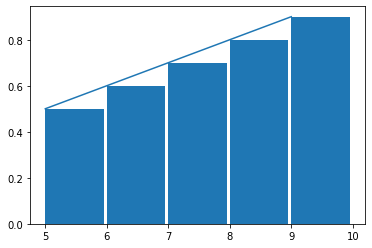

In [11]:
fig, ax = plt.subplots()
ax.plot(xs,ys)
ax.bar(xs,ys,width=0.95,align="edge")

In [19]:
plt.ion()

In [14]:
(1 - ys[:-1]) * xs[1:]-xs[:-1]

array([-2. , -3.2, -4.6, -6.2])

In [ ]:
widths = [xs[:-1]-xs[1:]]

In [21]:
xs =
ys = np.array([1.04715744 0.98819334 1.02592413 1.02166257 1.03455768 1.01709097, 0.98221768 0.97933651 1.03771797 1.03962419 1.00917493 1.0447162, 0.99249288 0.9967251  0.99070238 0.99348147 1.04331005 0.9670868, 1.03437053 0.98497765 1.01020621 1.02720962 0.99020627 0)
np.polyfit([184.28093645, 183.27759197, 183.61204013, 183.94648829, 184.28093645], [1.016433, 0.91477086, 0.98338828, 0.96866143, 1.016433], 1)

array([  0.08788547, -15.18040801])

In [37]:
xs = [121.40468227, 121.73913043, 122.0735786,  122.40802676, 122.74247492,
      123.07692308, 123.41137124, 123.7458194,  124.08026756, 124.41471572,
      124.74916388, 125.08361204, 125.4180602]
ys = [1.01004131, 0.97487609, 0.97846517, 1.00198473, 1.04623203, 0.94820867,
      1.03169420, 1.03313939, 1.00295517, 0.99454967, 0.99261907, 1.00165154,
      1.02910168]

In [38]:
np.polyfit(xs, ys, 1)

array([0.00461523, 0.43392989])

In [ ]:
sum(1 - self.config.ys_norm[indmin:indmax]) * (self.config.xs[indmin+1:indmax+1] - self.config.xs[indmin:indmax])

In [39]:
a = np.array([1,2,3])
b = np.array([2,2,2])
a*b

array([2, 4, 6])